In [61]:
# import
import numpy
import pandas as pd
import numpy as np
import os

from PIL import Image

from PIL.Image import Resampling
from PIL import ImageOps
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [76]:
img_rows, img_cols = 70, 70
images_dir = '../datasets/images/'
artists = pd.read_csv('../datasets/artists.csv')
n_paintings = artists['paintings'].sum()
artists = artists.sort_values(by=['paintings'], ascending=False)

artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]

n_artists = len(artists_top['name'])
n_required_img = 400
max_paintings = artists_top['paintings'][0]
part_of_test = 5
n_gen_image = 5
artists_top

,name,paintings
0,Vincent van Gogh,877
1,Edgar Degas,702
2,Pablo Picasso,439
3,Pierre-Auguste Renoir,336
4,Albrecht Durer,328
5,Paul Gauguin,311
6,Francisco Goya,291
7,Rembrandt,262
8,Alfred Sisley,259
9,Titian,255


In [63]:
def resize_image(artist, image):
    image_file = os.path.join(images_dir, artist, image)
    im = Image.open(image_file)

    thumb = im.resize((img_rows, img_cols), Resampling.LANCZOS)
    gray = ImageOps.grayscale(thumb)
    data = np.asarray(gray)
    reshaped = data.reshape(1, img_rows, img_cols, 1)
    return reshaped

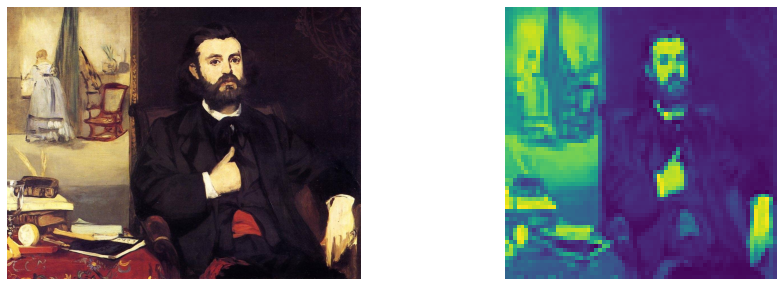

In [30]:
# example of resizing image

artist_ex = 'Edouard_Manet'
image_ex = 'Edouard_Manet_3.jpg'

image = plt.imread(os.path.join(images_dir, artist_ex, image_ex))
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(image)
axes[0].axis('off')

resized_image = resize_image(artist_ex, image_ex)
axes[1].imshow(resized_image[0])
axes[1].axis('off')

plt.show()

In [31]:
def artist_images_by_id(id):
    artist = artists_top['name'][id].replace(' ', '_')
    images = os.listdir(os.path.join(images_dir, artist))
    return artist, images

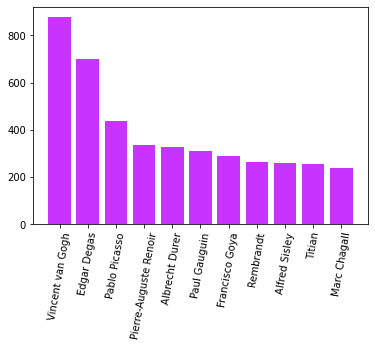

In [32]:
plt.xticks(rotation=80)
plt.bar(artists_top['name'], artists_top['paintings'], color='#C833FF')
plt.show()

In [33]:
train_datagen = ImageDataGenerator(
                                   # validation_split=0.2,
                                   # rescale=1. / 255.,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.2,
                                   # shear_range=5,
                                   #zoom_range=0.1,
                                   horizontal_flip=True,
                                   # vertical_flip=True,
                                   )

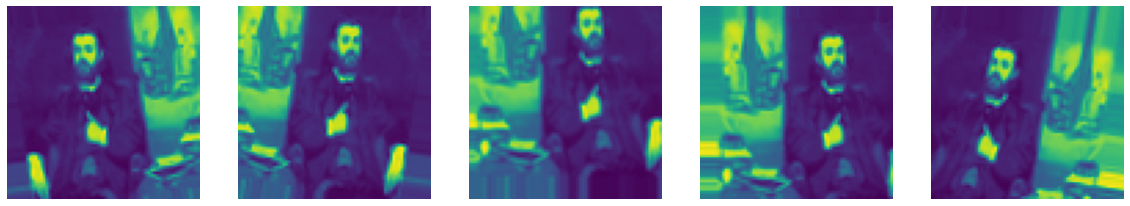

In [58]:
# example of Image Data Augmentation
train_datagen.fit(resized_image)
image_iterator = train_datagen.flow(resized_image)

fig, rows = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for row in rows:
    row.imshow(image_iterator.next()[0].astype('int'))
    row.axis('off')
plt.show()

In [59]:
def add_row(X, res):
    if len(X[0]) == 0:
        X = res[0].reshape(1, img_rows * img_cols)
    else:
        X = numpy.vstack([X, res[0].reshape(1, img_rows * img_cols)])
    return X

In [64]:
def prepare_train_data():
    X = [[]]
    Y = []
    for i in range(n_artists):
        artist, images = artist_images_by_id(i)
        start, stop = 0, len(images) - int(len(images) / part_of_test)
        n_need_add = int((n_required_img - stop) / n_gen_image)

        for j in range(start, stop):
            Y.append(artist)
            reshaped = resize_image(artist, images[j])

            X = add_row(X, reshaped)

            if n_need_add > 0:
                train_datagen.fit(reshaped)
                image_iterator = train_datagen.flow(reshaped)

                for m in range(n_gen_image):
                    X = numpy.vstack([X, image_iterator.next()[0].astype('int').flatten()])
                    Y.append(artist)

                n_need_add -= 1
    return X, Y

In [65]:
def prepare_test_data():
    X = [[]]
    Y = []
    for i in range(n_artists):
        artist, images = artist_images_by_id(i)
        start, stop = len(images) - int(len(images) / part_of_test), len(images)

        for j in range(start, stop):
            Y.append(artist)
            X = add_row(X, resize_image(artist, images[j]))

    return X, Y

In [66]:
class LogisticModel():

    def __init__(self, artist):
        self.artist = artist
        self.mod = LogisticRegression(tol=0.001, max_iter=10000, solver='liblinear')

    def Train(self, xfull, yfull):
        xi = xfull
        y = yfull

        y2 = [1 if y[i] == self.artist else 0 for i in range(len(y))]
        self.mod.fit(xi, y2)
        print("Trained model for {}.".format(self.artist))
        return self.mod

    def Predict(self, xi):
        pro = self.mod.predict_proba([xi])
        return pro[0][1]

In [67]:
def value_count_from_list(list):
    freq = {}
    for item in list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    return freq

In [77]:
x_train, y_train = prepare_train_data()

In [78]:
artist_n_img = value_count_from_list(y_train)

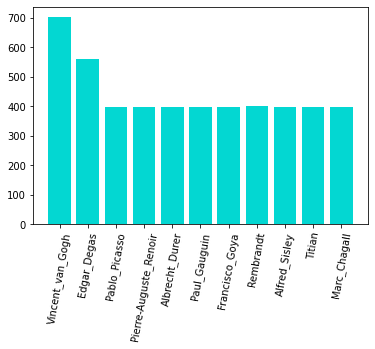

In [79]:
plt.xticks(rotation=80)
plt.bar(artist_n_img.keys(), artist_n_img.values(), color='#03D7D2')
plt.show()

In [80]:
lms = []
for i in range(n_artists):
    lm = LogisticModel(artists_top['name'][i].replace(' ', '_'))
    lm.Train(x_train, y_train)
    lms.append(lm)

Trained model for Vincent_van_Gogh.
Trained model for Edgar_Degas.
Trained model for Pablo_Picasso.
Trained model for Pierre-Auguste_Renoir.
Trained model for Albrecht_Durer.
Trained model for Paul_Gauguin.
Trained model for Francisco_Goya.
Trained model for Rembrandt.
Trained model for Alfred_Sisley.
Trained model for Titian.
Trained model for Marc_Chagall.


In [ ]:
x_test, y_test = prepare_test_data()

In [83]:
def predict(x):
    res = -1
    maximum = -1000
    for d in range(n_artists):
        prob = lms[d].Predict(x)
        if prob > maximum:
            maximum = prob
            res = d
    return lms[res].artist

In [86]:
y_test[90], predict(x_test[90])

('Vincent_van_Gogh', 'Vincent_van_Gogh')

In [89]:
wrong = []
ntot = x_test.shape[0]
for i in range(ntot):
    x = x_test[i]
    y = y_test[i]
    yy = predict(x)
    if i % 100 == 0: print(i)
    if yy == y: continue
    wrong.append([i, yy])

nfalse = len(wrong)
ntrue = ntot - nfalse
print('Correct {} out of {}, accuracy = {}%'.format(ntrue, ntot, ntrue * 100 / ntot))

0
100
200
300
400
500
600
700
800
Correct 211 out of 855, accuracy = 24.678362573099417%
